In [1]:
using Dates, JLD2, FileIO, Unicode, Plots, Printf, JuliaDB;

In [2]:
function makeCompDict(wcafile)
    compids = String[]
    compdates = Date[]
    lines = readlines(wcafile)
    for i = 2:length(lines) # skip header line
        line = lines[i]
        data = split(line, "\t")
        push!(compids, data[1])
        compdate = string(data[6], "-", data[7], "-", data[8])
        push!(compdates, Date(compdate, "y-m-d"))
    end
        compDict = Dict(zip(compids, compdates))
        sortedCompsArray = sort(collect(zip(values(compDict),keys(compDict))))
    
    return compDict, sortedCompsArray
end

makeCompDict (generic function with 1 method)

In [3]:
function makeResults(wcafile)
    results = Any[]
    lines = readlines(wcafile)
    for i = 2:length(lines) # skip header line
        line = lines[i]
        data = split(line, "\t")
        compid = data[1]
        rs = [data[8], data[2], compDict[compid], parse(Int, data[11]), parse(Int, data[12]), parse(Int, data[13]), parse(Int, data[14]), parse(Int, data[15]), data[7], data[9]]
        push!(results, rs)
    end
    
    return results
end

makeResults (generic function with 1 method)

In [4]:
function makeEventResults(event)
    k = findall(x -> x[2] == event, Allresults)
    return Allresults[k]
end

makeEventResults (generic function with 1 method)

In [5]:
function findPersonResults(personid)
    personresults = []
    for i in 1:length(results)
        if results[i][1] == personid
            push!(personresults, results[i])
        end
    end
    return personresults
end

findPersonResults (generic function with 1 method)

In [6]:
function genAllDates(event)
    compDict, sortedCompsArray = makeCompDict("WCA_export_Competitions.tsv")
    output = []
    lengthOfComps = length(sortedCompsArray)
    for i in 1:length(sortedCompsArray)
        date = sortedCompsArray[i][1]
        count = 0
        roundTypes = ["0", "1", "2", "3", "b", "c", "d", "e", "f", "g", "h"]
        for j in 1:length(roundTypes)
            if isRound(sortedCompsArray[i][2], event, roundTypes[j])
                count+=1
            end
        end
        for i in 1:count
            push!(output, date)
        end
        print("\r $i / $lengthOfComps Comps  ||  $date")
    end
    return output
end

genAllDates (generic function with 1 method)

In [7]:
function LaZerRating(id, event, startDate, endDate, resultsDict)
    wcalimit = 60000 # 10:00 minutes (wca time limit)
    k = 43252003274489856000
    
    if !(haskey(resultsDict, id))
        rating = NaN
        nsolves = 0
        name = ""
        country = ""
        best = NaN
        lastcomp = 0
        wcaid = id
        return rating,nsolves,country,name,best,lastcomp, id
    end
    
    Allrs = resultsDict[id]
    rs = []
    sdate = Date(startDate[1], startDate[2], startDate[3])
    edate = Date(endDate[1], endDate[2], endDate[3])
    for i in Allrs
        if i[3] < edate && i[3] > sdate
            push!(rs, i)
        end
    end

    if length(rs) == 0
        rating = NaN
        nsolves = 0
        name = ""
        country = ""
        best = NaN
        lastcomp = 0
        wcaid = id
        return rating,nsolves,country,name,best,lastcomp, id
    end

    times = []
    for i in 1:length(rs), j in 4:8
        x = findall(x -> x == -1, rs[i])
        if length(x) >= 1
            if j != x[1]
                push!(times, rs[i][j])
            end
        else
            if rs[i][j] != maximum(rs[i][4:8])
                push!(times, rs[i][j])
            end
        end 
    end

    dates = []
    for i in 1:length(rs)
        append!(dates, repeat([rs[i][3]], inner=4))
    end

    skipk = findall(x-> x != -1 && x != -2 && x != 0, times)

    weights = []
    for i in 1:length(skipk)
        push!(weights, 1/(edate - dates[skipk][i]).value)
    end

    if length(weights) == 0
        rating = NaN
        nsolves = 0
        name = ""
        country = ""
        best = NaN
        lastcomp = 0
        wcaid = id
        return rating,nsolves,country,name,best,lastcomp, id
    else
        sw = sum(weights)
    end

    weighted_times = []
    for i in 1:length(skipk)
        push!(weighted_times, times[skipk][i]*weights[i])
    end

    rating = sum(weighted_times)/sw/100

    #percent DNF
    if event == "777" || event == "666" || event == "333fm" || event == "333ft" || event == "333bf"
        nsolves = length(rs)*5-(2/5)*length(rs)*5
    else
        nsolves = length(rs)*5
    end

    #additional person Info
    name = rs[1][9]
    country = rs[1][10]

    #best time
    if event == "333fm"
        best = minimum(times[skipk])
        rating = rating*100
    else
        best = minimum(times[skipk])/100
    end
    
    lastcomp = dates[end]
    wcaid = rs[1][1]

    return rating,nsolves,country,name,best,lastcomp, wcaid
end

LaZerRating (generic function with 1 method)

In [8]:
function printrt(rt)
    htb = @sprintf "%4s %-30s \t %7s %6s %-15s %6s %-10s" "Rank" "Name" "Rating" "Best" "Citizen of" "Solves" "Date Achieved"
    println(htb)
    for i in 1:length(rt)
        name = Unicode.normalize(rt[i][4])
        printname = ""
        for i = firstindex(name):min(lastindex(name), 30)
            try
                printname *= name[i]
            catch 
                # ignore the index error
            end
        end
        if lastindex(name) >= 30
            printname *= "..."
        end
        tb = @sprintf "%4d %30s \t %7.3f %6.2f %-15s %6d %10s" i  rpad(printname, 30) rt[i][1] rt[i][5] rpad(rt[i][3], 15) rt[i][2] rt[i][6]
        println(tb)
    end
end


printrt (generic function with 1 method)

In [9]:
function findRanks(wcafile, event)
    personids = String[]
    eventids = String[]
    lines = readlines(wcafile)
    for i = 2:length(lines) # skip header line
        line = lines[i]
        data = split(line, "\t")
        push!(personids, data[1])
        push!(eventids, data[2])
    end

    k = findall(x -> x == event, eventids)
    personsArray = personids[k]

    return personsArray
end

findRanks (generic function with 1 method)

In [10]:
function genRatings(event, num, startDate, endDate, resultsDict)
    Allranks = findRanks("WCA_export_RanksSingle.tsv", event)
    ranks = []
    for i in Allranks
        if parse(Int, i[1:4]) <= endDate[1]
            push!(ranks, i)
        end
    end
    ratingList = []
    for i in 1:length(ranks)
        lengthRanks = length(ranks)
        person = ranks[i]
        push!(ratingList, LaZerRating(ranks[i], event, startDate, endDate, resultsDict))
        #print("\r $i / $lengthRanks || $person")
    end
    ratingList = sort(ratingList)
    if num == 0
        num = length(ratingList)
    end
    outputRatingList = []
    for i in ratingList[1:num]
        if i[1] != NaN
            push!(outputRatingList, i)
        end
    end
    #printrt(outputRatingList)
    return outputRatingList
end

genRatings (generic function with 1 method)

In [11]:
function genHistory(id, event)
    date = Date(2003, 8, 1)
    history = []
    for i in 1:(round((today() - date).value/30))
        date += Dates.Month(1)
        endDate = [Dates.year(date), Dates.month(date), Dates.day(date)]
        startDate = [Dates.year(date - Dates.Month(6)), Dates.month(date - Dates.Month(6)), 
                   Dates.day(date - Dates.Month(6))]
        rating = LaZerRating(id, event, startDate, endDate, resultsDict)
        if date <= today() + Dates.Month(1)
            push!(history, [date, rating])
        end
    end
    return history
end

genHistory (generic function with 1 method)

In [12]:
function genDates()
    date = Date(2003, 8, 1)
    history = []
    for i in 1:(round((today() - date).value/30))
        date += Dates.Month(1)
        if date <= today() + Dates.Month(1)
            push!(history, date)
        end
    end
    return history
end

genDates (generic function with 1 method)

In [13]:
function plotArray(id, event)
    full = genHistory(id, event)
    out = []
    for x in full
        push!(out, x[2][1])
    end
    return out
end

plotArray (generic function with 1 method)

In [14]:
function plotArrays(event)
    ids = plotIds(event)
    plotAs = []
    for id in ids
        push!(plotAs, plotArray(id, event))
        print("\r$id")
    end
    return ids, plotAs
end

plotArrays (generic function with 1 method)

In [15]:
function genResultsDict(event)
    results = makeEventResults(event)
    wcaids = findRanks("WCA_export_RanksSingle.tsv", event)
    resultsDict = Dict()
    for id in wcaids
        resultsDict[id] = []
    end
    for r in results
        if haskey(resultsDict, r[1])
            resultsDict[r[1]] = push!(resultsDict[r[1]], r)
        end
    end
    return resultsDict
end

genResultsDict (generic function with 1 method)

In [16]:
function plotIds(event)
    date = Date(2004, 1, 1)
    ids = []
    for i in 1:(round((today() - date).value/30.44/6))
        date += Dates.Month(6)
        endDate = [Dates.year(date), Dates.month(date), Dates.day(date)]
        startDate = [Dates.year(date - Dates.Month(6)), Dates.month(date - Dates.Month(6)), 
                   Dates.day(date - Dates.Month(6))]
        ratings = genRatings(event, 100, startDate, endDate)
        for r in ratings
            push!(ids, r[7])        
        end
    end
    truncatedIds = []
    for id in ids
        if !in(id, truncatedIds)
            push!(truncatedIds, id)
        end
    end
    return truncatedIds
end

plotIds (generic function with 1 method)

In [17]:
function genTable(ratings)
    rankA = Int[]
    ratingA = Float64[]
    nsolvesA = Int[]
    countryA = String[]
    nameA = String[]
    bestA = Float64[]
    dateA = Any[]
    wcaidA = String[]
    for i in 1:length(ratings)
        push!(rankA, i)
        push!(ratingA, ratings[i][1])
        push!(nsolvesA, round(ratings[i][2]))
        push!(countryA, ratings[i][3])
        push!(nameA, ratings[i][4])
        push!(bestA, ratings[i][5])
        push!(dateA, ratings[i][6])
        push!(wcaidA, ratings[i][7])
    end
    outTable = table(rankA, ratingA, nsolvesA, countryA, nameA, bestA, dateA, wcaidA, 
                     names=[:Rank, :Rating, :nSolves, :Country, :Name, :Best, :Date, :WcaId])
    return outTable
end

genTable (generic function with 1 method)

In [18]:
function genTop1000CSV(event)
    resultsDict = genResultsDict(event)
    ratings = genRatings(event, 1000, startDate, endDate, resultsDict)
    filename = event*"Top1000_Jan_2019.csv"
    FileIO.save("$filename", genTable(ratings))
end

genTop1000CSV (generic function with 1 method)

In [19]:
function genTop300CSV(event, date)
    resultsDict = genResultsDict(event)
    ratings = genRatings(event, 300, startDate, endDate, resultsDict)
    filename = event*"Top300_Jan_2019.csv"
    FileIO.save("$filename", genTable(ratings))
end

genTop300CSV (generic function with 1 method)

In [20]:
function genCSV(event, date)
    resultsDict = genResultsDict(event)
    ratings = genRatings(event, 0, startDate, endDate, resultsDict)
    filename = ""*event*"_"*date*".csv"
    FileIO.save(filename, genTable(ratings))
end

genCSV (generic function with 1 method)

In [21]:
function genAllTop1000CSV(date)
    genTop1000CSV("222", date)
    genTop1000CSV("333", date)
    genTop1000CSV("444", date)
    genTop1000CSV("555", date)
    genTop1000CSV("666", date)
    genTop1000CSV("777", date)
    genTop1000CSV("minx", date)
    genTop1000CSV("pyram", date)
    genTop1000CSV("skewb", date)
    genTop1000CSV("sq1", date)
    genTop1000CSV("clock", date)
    genTop1000CSV("333oh", date)
    genTop1000CSV("333bf", date)
    genTop1000CSV("333ft", date)
    genTop1000CSV("333fm", date)
    genTop300CSV("444bf", date)
    genTop300CSV("555bf", date)
end

genAllTop1000CSV (generic function with 1 method)

In [22]:
function genAllCSV(date)
    genCSV("222", date)
    genCSV("333", date)
    genCSV("444", date)
    genCSV("555", date)
    genCSV("666", date)
    genCSV("777", date)
    genCSV("minx", date)
    genCSV("pyram", date)
    genCSV("skewb", date)
    genCSV("sq1", date)
    genCSV("clock", date)
    genCSV("333oh", date)
    genCSV("333bf", date)
    genCSV("333ft", date)
    genCSV("333fm", date)
    genCSV("444bf", date)
    genCSV("555bf", date)
end

genAllCSV (generic function with 1 method)

In [23]:
compDict, sortedCompsArray = makeCompDict("WCA_export_Competitions.tsv")

(Dict("JaenMountainCubes2018"=>2018-10-13,"HelsinkiBlindWeekend2015"=>2015-08-15,"SanLorenzoInvierno2015"=>2015-08-15,"AustrianOpen2016"=>2016-06-18,"TokaiOpen2014"=>2014-12-06,"FinnishOpen2016"=>2016-04-16,"DniproCubeGeneration2018"=>2018-04-28,"ThailandChampionship2014"=>2014-06-21,"IICEFETMGUAIBitsOpen2018"=>2018-05-05,"ByczyCubeRace2017"=>2017-06-24…), Tuple{Date,String}[(1982-06-05, "WC1982"), (2003-08-23, "WC2003"), (2003-10-11, "DutchOpen2003"), (2004-01-24, "CaltechWinter2004"), (2004-04-03, "CaltechSpring2004"), (2004-04-16, "France2004"), (2004-04-24, "GermanOpen2004"), (2004-07-10, "US2004"), (2004-08-07, "Euro2004"), (2004-10-10, "DutchOpen2004")  …  (2019-06-08, "HighWycombeOpen2019"), (2019-06-29, "BritishSummerOpen2019"), (2019-06-29, "SwisscubingCupIII2019"), (2019-07-03, "WarmUpCanberra2019"), (2019-07-05, "VisayasChampionship2019"), (2019-07-06, "WarmUpSydney2019"), (2019-07-11, "WC2019"), (2019-07-13, "CubingHeredia2019"), (2019-08-01, "CubingUSANationals2019"), (201

In [24]:
Allresults = makeResults("WCA_export_Results.tsv")

2020611-element Array{Any,1}:
 Any["2007AMAN01", "333", 2007-09-01, 1968, 2203, 2138, 2139, 2108, "Etienne Amany", "Cote d_Ivoire"]   
 Any["2004ROUA01", "333", 2007-09-01, 2222, 2153, 1731, 2334, 2046, "Thomas Rouault", "France"]         
 Any["2005SIMO01", "333", 2007-09-01, 3430, 2581, 2540, 2789, 2305, "Antoine Simon-Chautemps", "France"]
 Any["2007MALL01", "333", 2007-09-01, 2715, 2452, 2868, 2632, 2564, "Irène Mallordy", "France"]         
 Any["2007DESM01", "333", 2007-09-01, 2921, 3184, 2891, 2677, 2907, "Marlène Desmaisons", "France"]     
 Any["2003DENN01", "333", 2007-09-01, 3309, 1869, 2558, 2930, 3241, "Ton Dennenbroek", "Netherlands"]   
 Any["2006GALE01", "333", 2007-09-01, 2530, 2696, 2411, 5512, 3503, "Arnaud van Galen", "Netherlands"]  
 Any["2007CORN01", "333", 2007-09-01, 2844, 3861, 2628, 3885, 2385, "Cyrille Cornu", "France"]          
 Any["2005WOIT01", "333", 2007-09-01, 3084, 3163, 3087, 3498, 2639, "Christophe Woittequand", "France"] 
 Any["2007POIN01", "333",

In [25]:
startDate, endDate = [2018,8,1], [2019,2,1]

([2018, 8, 1], [2019, 2, 1])

In [26]:
genAllCSV("Feb_2019")

In [160]:
ids, plotAs = plotArrays("333")

2015SHAY01

(Any["2003MAKI01", "2003VAND01", "2003BRUC01", "2003TEMP01", "2004VIEN01", "2003BADI01", "2004SCHO01", "2004BECH01", "1982PETR01", "2003JANS01"  …  "2017WONG01", "2016LIGH01", "2017KILS01", "2016ISID01", "2016ULKU01", "2013UVES01", "2009ALFA01", "2014XUDA01", "2017YANG59", "2015SHAY01"], Any[Any[22.4075, 22.4075, 22.4075, 22.4075, 22.4075, 18.1527, 16.0837, 16.0837, 15.4207, 15.4207  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], Any[19.9488, 19.9488, 19.828, 19.828, 19.828, 19.828, 18.87, 18.87, 16.935, 16.935  …  16.5725, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], Any[21.1375, 21.1375, 20.8589, 20.8589, 20.8589, 20.8589, 18.65, 18.65, 19.3925, 19.3925  …  14.3275, 14.2311, 14.0668, 14.0252, 14.2231, 14.267, 14.1239, 14.2273, 14.0588, 14.1342], Any[23.845, 23.845, 23.845, 23.845, 23.845, 23.845, NaN, NaN, 20.595, 20.595  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 20.9975, 20.9975  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, Na

In [169]:
plotDict = Dict(zip(ids, plotAs))

Dict{Any,Any} with 759 entries:
  "2003CAMA01" => Any[20.8975, 20.8975, 20.8975, 20.8975, 20.8975, 20.8975, NaN…
  "2007OGAW01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN,…
  "2004SULL01" => Any[NaN, NaN, NaN, NaN, NaN, 169.035, 169.035, 169.035, 169.0…
  "2008LIBI01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN,…
  "2010GARC02" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  8.34…
  "2005LEVI01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN,…
  "2014SEBA01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  8.82…
  "2006STEW01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN,…
  "2006JACQ01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN,…
  "2004YUAL01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 54.765, 54.765  ……
  "2010LEEY01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN,…
  "2004REYP01" => Any[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  Na

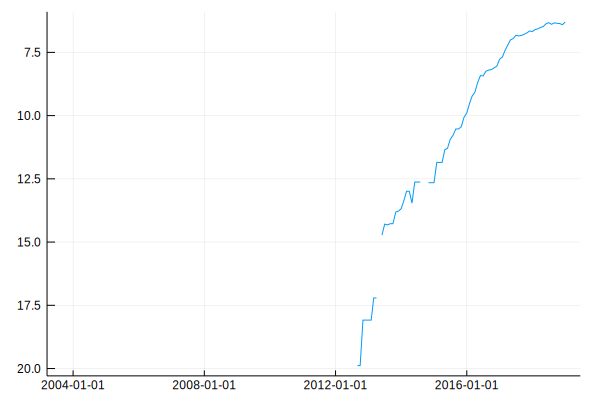

In [192]:
x = genDates()
plot(x, plotDict["2012PARK03"], yflip=true, legend=false)

In [40]:
typeof(6.34)

Float64